# **Visializar datos**

En este cuaderno hay ejemplos de como se podrían ver los archivos midi, de ser posible agregar la mejora de:

- Hacer que funcione el convertor de MIDI a WAV para poder reproducirlo en la misma app y no tener que usar la página de https://www.freeconvert.com/es/mid-to-wav

In [1]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio, display
import music21
#from music21 import *
from music21 import environment, note, chord, stream, converter, instrument, note, chord
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from tqdm import tqdm
import sys
import warnings
import glob
import os


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

### **Importación de archivos `.mid`**

In [2]:
import glob

files = glob.glob("data/**/*.mid", recursive=True)
print("Total archivos MIDI:", len(files))
print(files[:5])


Total archivos MIDI: 295
['data\\albeniz\\alb_esp1.mid', 'data\\albeniz\\alb_esp2.mid', 'data\\albeniz\\alb_esp3.mid', 'data\\albeniz\\alb_esp4.mid', 'data\\albeniz\\alb_esp5.mid']


## **Ver Metadata de archivos**

In [3]:
from mido import MidiFile

mid = MidiFile(files[0])
print("Ticks por beat:", mid.ticks_per_beat)

for i, track in enumerate(mid.tracks):
    print(f"Track {i}: {track.name}")
    for msg in track[:10]:
        print(msg)


Ticks por beat: 480
Track 0: Espana Op. 165
MetaMessage('track_name', name='Espana Op. 165', time=0)
MetaMessage('track_name', name='Prelude', time=0)
MetaMessage('copyright', text='Copyright © 2001 by Bernd Krueger', time=0)
MetaMessage('text', text='Isaac Albeniz', time=0)
MetaMessage('text', text='Andantino', time=0)
MetaMessage('text', text='Fertiggestellt  27.01.2001\n', time=0)
MetaMessage('text', text='Update: 18.03.2001\n', time=0)
MetaMessage('text', text='Normierung: 23.12.2002\n', time=0)
MetaMessage('text', text='Update am 28.10.2010\n', time=0)
MetaMessage('text', text='Dauer: 1:36 Minuten\n', time=0)
Track 1: Piano right
MetaMessage('track_name', name='Piano right', time=0)
program_change channel=0 program=0 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=64 time=0
MetaMessage('text', text='bdca426d104a26ac9dcb070447587523', time=0)
control_change channel=0 control=91 value=127 time=0
control_change channel=0 control=64

## **Ver instrumento de pista con notas**

In [4]:
import pretty_midi

pm = pretty_midi.PrettyMIDI(files[3])

# Lista instrumentos
for instrument in pm.instruments:
    print("Instrumento:", instrument.name, " | Notas:", len(instrument.notes))

# Acceder a notas
notes = pm.instruments[0].notes
for n in notes[:10]:
    print(f"Nota {n.pitch}, inicio {n.start:.2f}, fin {n.end:.2f}")


Instrumento: Piano right  | Notas: 843
Instrumento: Piano left  | Notas: 555
Nota 79, inicio 0.00, fin 0.14
Nota 74, inicio 0.27, fin 0.40
Nota 75, inicio 0.54, fin 0.67
Nota 79, inicio 0.80, fin 0.93
Nota 78, inicio 1.07, fin 1.20
Nota 81, inicio 1.33, fin 1.46
Nota 79, inicio 1.60, fin 1.68
Nota 81, inicio 1.68, fin 1.77
Nota 79, inicio 1.77, fin 1.86
Nota 78, inicio 1.86, fin 1.99


### **Ver como Piano Roll**

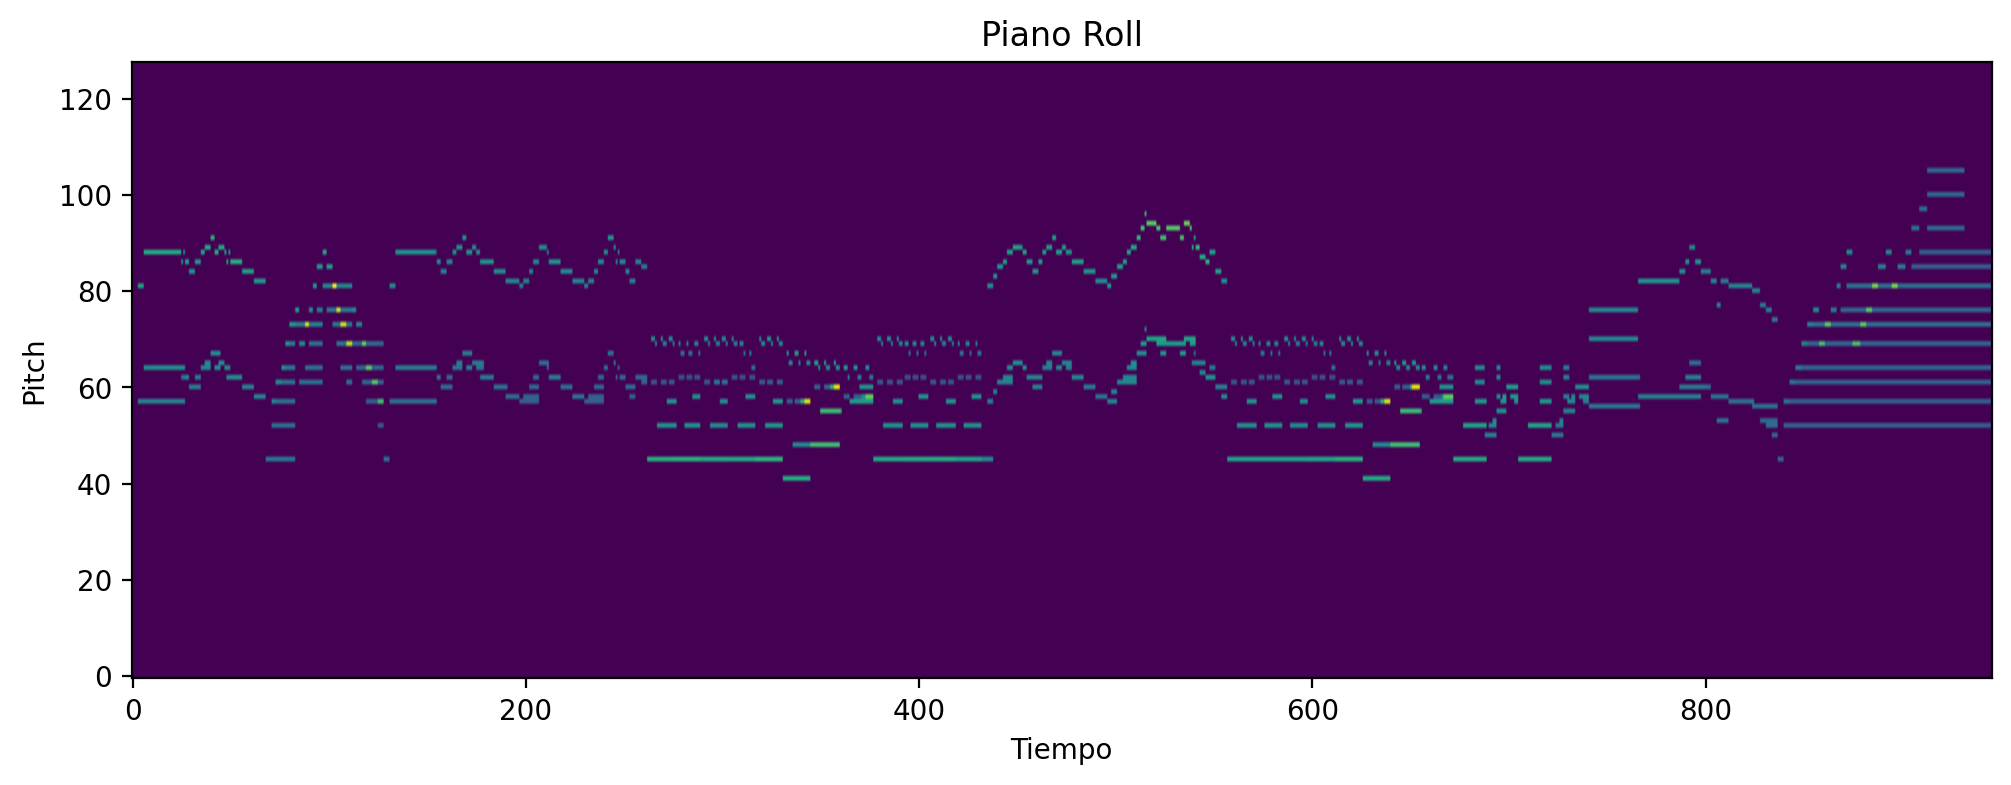

In [5]:
import matplotlib.pyplot as plt

pm = pretty_midi.PrettyMIDI(files[0])
plt.figure(figsize=(12, 4))
plt.imshow(pm.get_piano_roll(fs=10), aspect='auto', origin='lower')
plt.xlabel("Tiempo")
plt.ylabel("Pitch")
plt.title("Piano Roll")
plt.show()


### **Ver Pentagrama**

> Solo me ha funcionado para 40 notas, se podría usar el script de generar varios pero ir juntando las imágenes para que sea una sola

<span style="color:red;">**Contras:**</span> Podría llegar a ser muy pesado

<span style="color:green;">**Pros:**</span> Sería un buen toque para que se vea más pro

In [6]:
us = environment.UserSettings()
us['lilypondPath'] = r"C:\Users\drkfa\Downloads\lilypond-2.24.4-mingw-x86_64\lilypond-2.24.4\bin\lilypond.exe"
us['lilypondFormat'] = 'png'


from music21 import note, chord, stream, meter, tempo

def build_stream_from_sequence(seq):
    """Construye un stream a partir de una lista de notas o acordes (C4, E4, 60, etc.)."""
    melody = stream.Part()  # <-- en lugar de stream.Stream()
    melody.append(tempo.MetronomeMark(number=90))
    melody.append(meter.TimeSignature('4/4'))

    offset = 0
    for token in seq:
        if "." in token or token.isdigit():
            parts = token.split(".")
            notes_list = []
            for n in parts:
                try:
                    n_obj = note.Note(int(n))
                except ValueError:
                    n_obj = note.Note(n)
                notes_list.append(n_obj)
            c = chord.Chord(notes_list)
            c.quarterLength = 1  # duración fija
            c.offset = offset
            melody.append(c)
        else:
            n = note.Note(token)
            n.quarterLength = 1
            n.offset = offset
            melody.append(n)
        offset += 1

    # Empaquetar en un Score (mejor maquetación)
    score = stream.Score()
    score.insert(0, melody)
    return score


def show_stream_as_image(melody_stream):
    try:
        png_path = melody_stream.write("lily.png")
        print("Usando Lily")
        display(Image(png_path))
    except Exception as e:
        print(f"Error usando Lily:\n{e}")





In [7]:
from music21 import converter, instrument, note, chord

def extract_corpus_from_midi(midi_path):
    """Extrae notas y acordes de un archivo MIDI y devuelve una lista tipo ['C4', 'E4', 'G4', 'C4.E4.G4', ...]"""
    print(f"Procesando archivo: {midi_path}")
    try:
        midi = converter.parse(midi_path)
    except Exception as e:
        print("❌ Error al leer el archivo:", e)
        return []
    
    corpus = []
    parts = instrument.partitionByInstrument(midi)
    
    # Si el archivo tiene instrumentos definidos
    if parts:
        for part in parts.parts:
            notes_to_parse = part.recurse()
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    corpus.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # Unimos las notas del acorde con puntos
                    corpus.append('.'.join(str(n.pitch) for n in element.notes))
    else:
        # Si no hay instrumentos (una sola pista plana)
        for element in midi.flat.notes:
            if isinstance(element, note.Note):
                corpus.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                corpus.append('.'.join(str(n.pitch) for n in element.notes))
    
    print(f"Total de notas y acordes extraídos: {len(corpus)}")
    return corpus


In [8]:
midi_path = "data/bach/bach_846.mid"
# Canción corta
Corpus = extract_corpus_from_midi(midi_path)

# Canción larga
Corpus2 = extract_corpus_from_midi("data/bach/bach_847.mid")

Procesando archivo: data/bach/bach_846.mid
Total de notas y acordes extraídos: 45
Procesando archivo: data/bach/bach_847.mid
Total de notas y acordes extraídos: 1580


In [9]:
print(Corpus[:40])
print(Corpus2[:40])

['C5.E-4', 'C3', 'G3.F3', 'D4', 'E-4', 'G3.E-3', 'C4.E-4', 'G3', 'D4.E-4', 'F3.G3', 'C5.E-4', 'C3.G3', 'D4.E-4', 'F3', 'G3', 'C4', 'E-3.G3', 'E-4', 'D4.E-4', 'F3', 'G3', 'G#4', 'C3.G#3', 'F4.E4', 'G3', 'F4', 'G#3.F3', 'C4', 'F4', 'G#3', 'E4', 'G3', 'F4', 'G#3', 'G#4', 'C3', 'F4', 'G#3', 'E4.F4', 'G3']
['C5.E-4', 'C3', 'G3.F3', 'D4', 'E-4', 'G3.E-3', 'C4.E-4', 'G3', 'D4.E-4', 'F3.G3', 'C5.E-4', 'C3.G3', 'D4.E-4', 'F3', 'G3', 'C4', 'E-3.G3', 'E-4', 'D4.E-4', 'F3', 'G3', 'G#4', 'C3.G#3', 'F4.E4', 'G3', 'F4', 'G#3.F3', 'C4', 'F4', 'G#3', 'E4', 'G3', 'F4', 'G#3', 'G#4', 'C3', 'F4', 'G#3', 'E4.F4', 'G3']


In [10]:
def show_stream_in_chunks(stream_obj, chunk_size=40):
    """
    Muestra una partitura larga en fragmentos seguros de `chunk_size` notas cada uno.
    Evita los errores de LilyPond por archivos muy grandes.
    """
    notes = list(stream_obj.flat.notes)
    total = len(notes)
    print(f"🎼 Mostrando {total} notas en fragmentos de {chunk_size}")

    for i in range(0, total, chunk_size):
        sub_stream = stream.Stream(notes[i:i+chunk_size])
        sub_score = stream.Score()
        sub_score.insert(0, sub_stream)
        print(f"→ Fragmento {i}–{min(i+chunk_size, total)}")

        try:
            png_path = sub_score.write("lily.png")
            display(Image(png_path))
        except Exception as e:
            print(f"⚠️ Falló renderizado en fragmento {i}: {e}")
            # fallback a musicxml
            try:
                png_path = sub_score.write("musicxml.png")
                display(Image(png_path))
            except Exception as e2:
                print(f"❌ Falló también con MusicXML: {e2}")


🎼 Mostrando 45 notas en fragmentos de 30
→ Fragmento 0–30


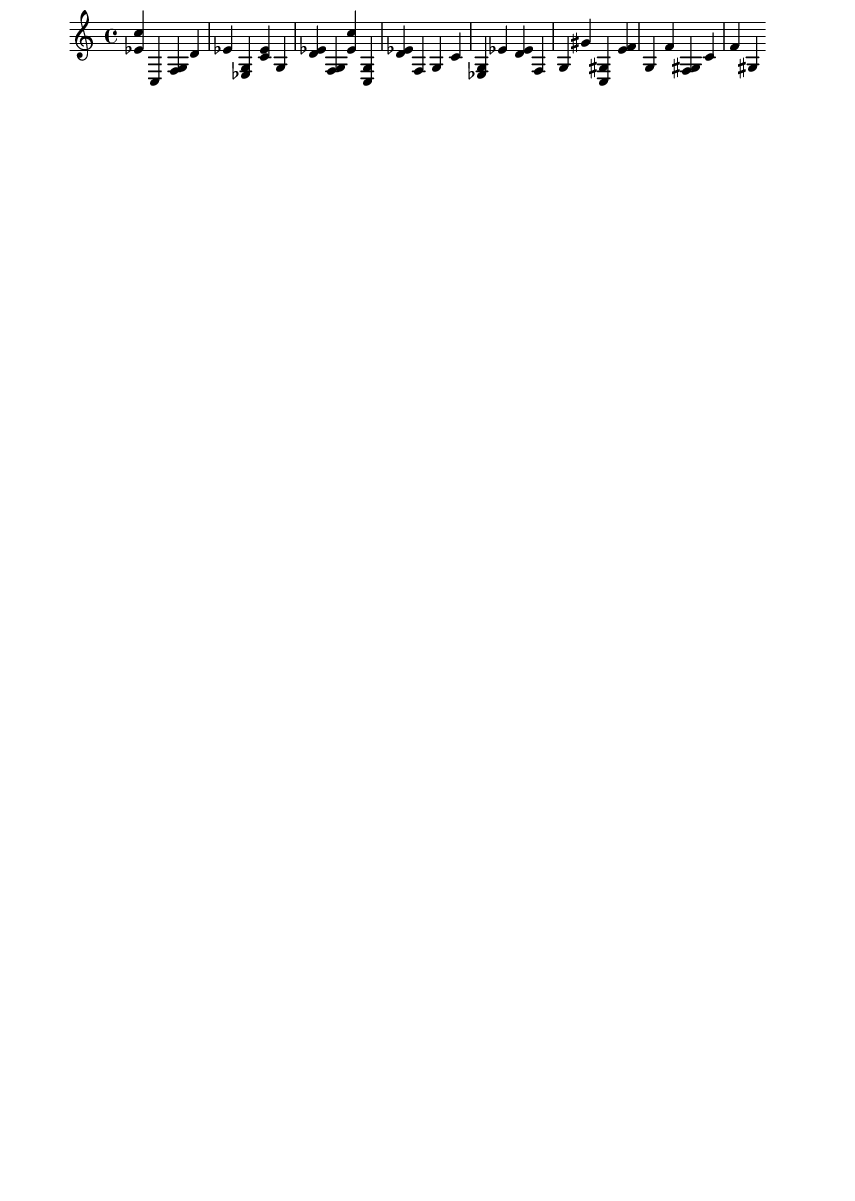

→ Fragmento 30–45


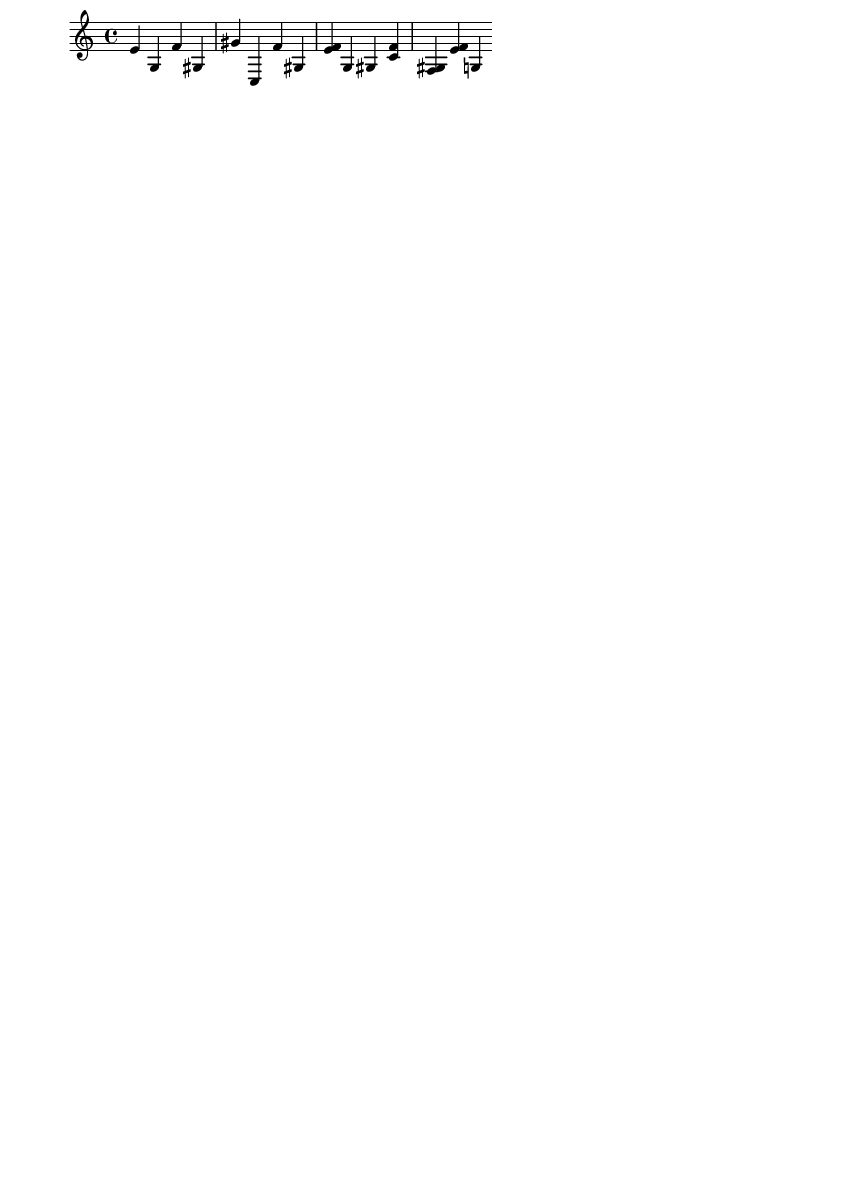

In [11]:
snippet = build_stream_from_sequence(Corpus[:90])
show_stream_in_chunks(snippet, chunk_size=30)

### **Ver más de 40 notas**
En este caso se genera una imagen por cada línea del pentagrama

🎼 Mostrando 90 notas en fragmentos de 30
→ Fragmento 0–30


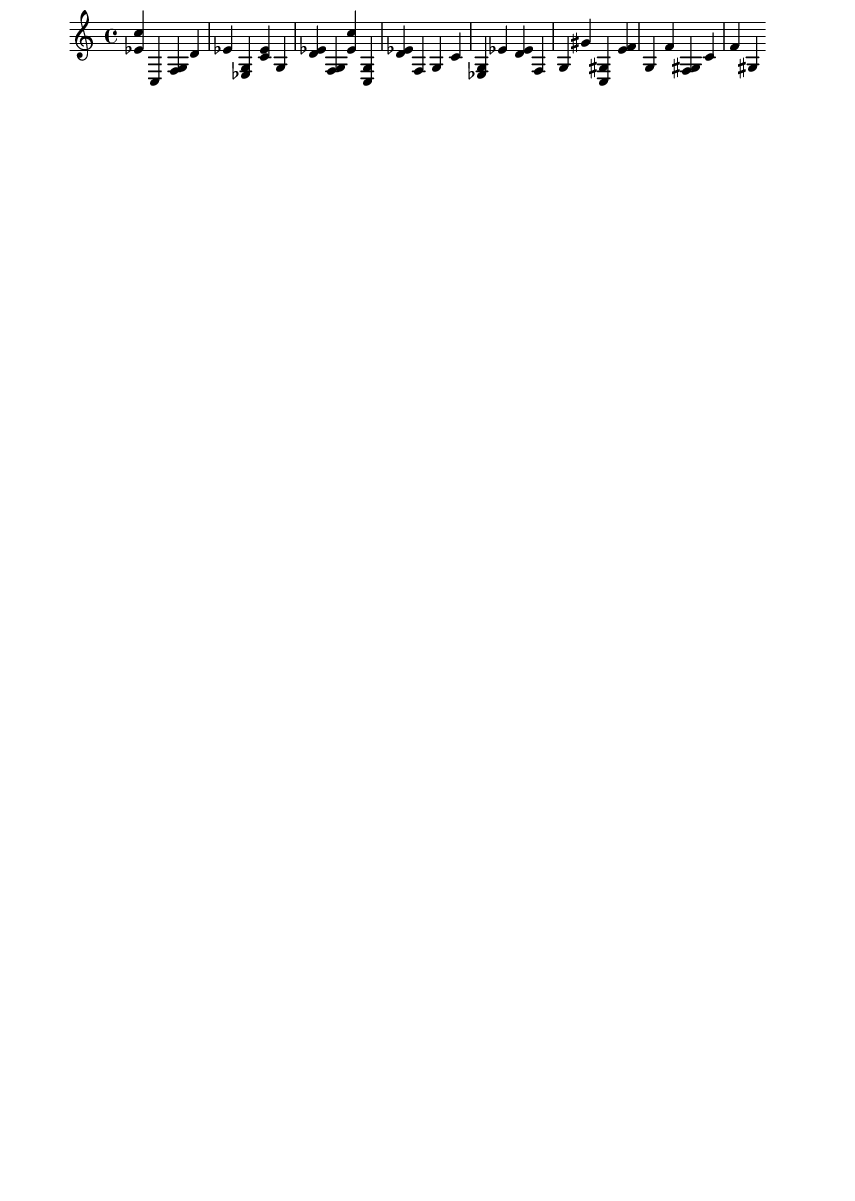

→ Fragmento 30–60


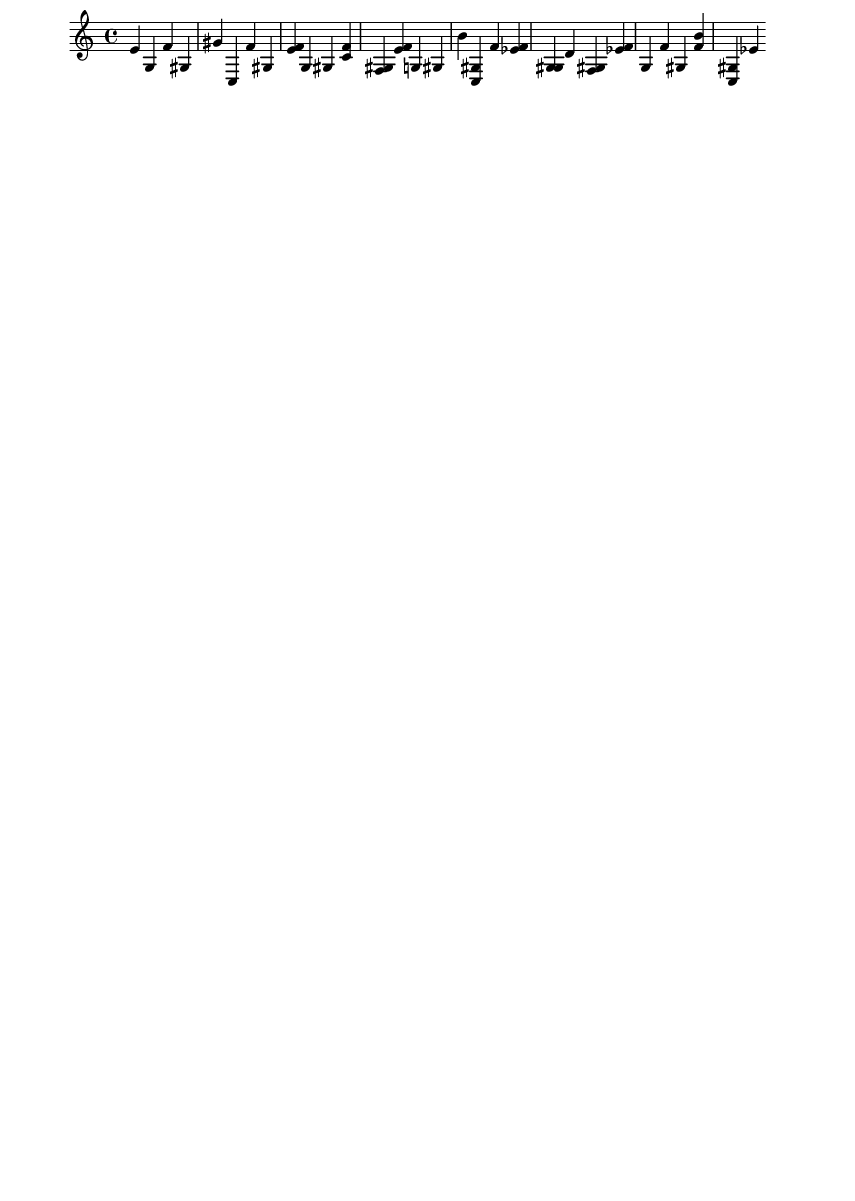

→ Fragmento 60–90


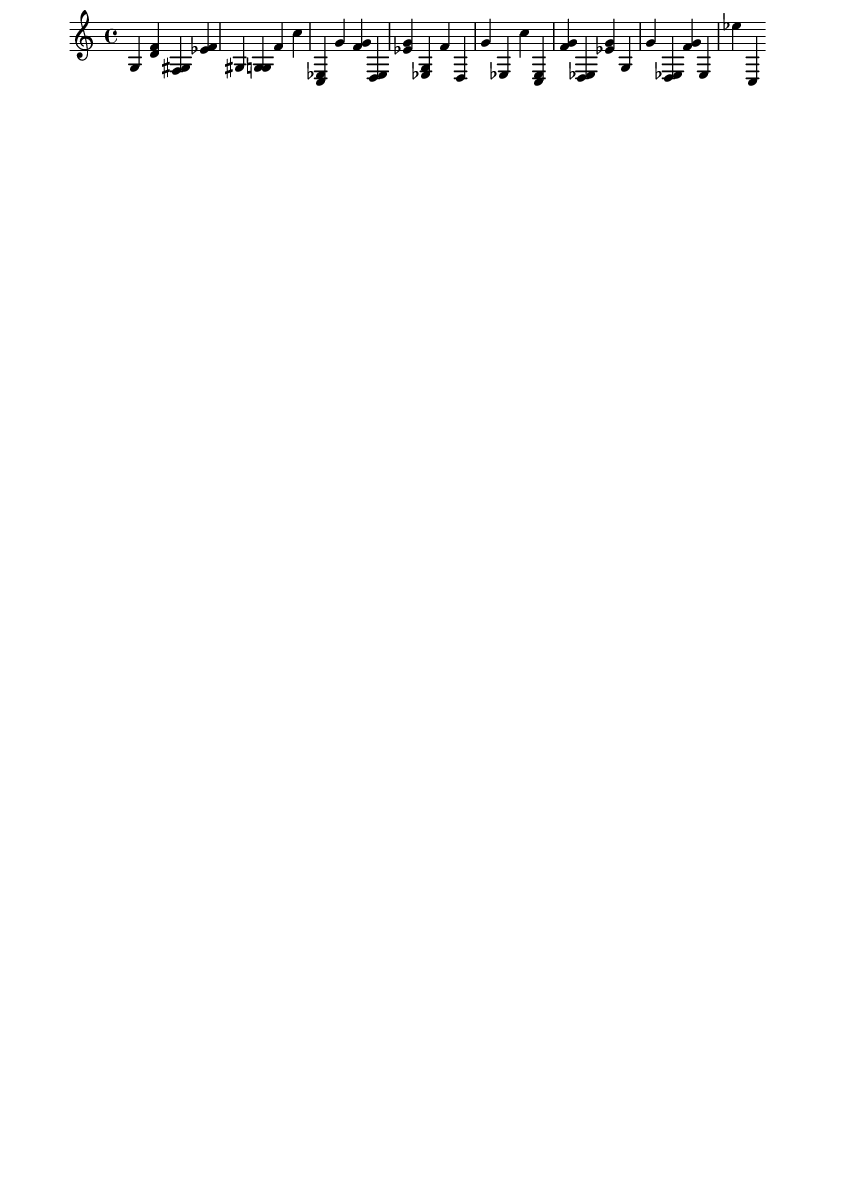

In [17]:
snippet = build_stream_from_sequence(Corpus2[:90])
show_stream_in_chunks(snippet, chunk_size=30)


### **Ver los tokens con su index**

{0.0} <music21.chord.Chord C5 E-4>
{1.0} <music21.note.Note C>
{2.0} <music21.chord.Chord G3 F3>
{3.0} <music21.note.Note D>
{4.0} <music21.note.Note E->
{5.0} <music21.chord.Chord G3 E-3>
{6.0} <music21.chord.Chord C4 E-4>
{7.0} <music21.note.Note G>
{8.0} <music21.chord.Chord D4 E-4>
{9.0} <music21.chord.Chord F3 G3>
{10.0} <music21.chord.Chord C5 E-4>
{11.0} <music21.chord.Chord C3 G3>
{12.0} <music21.chord.Chord D4 E-4>
{13.0} <music21.note.Note F>
{14.0} <music21.note.Note G>
{15.0} <music21.note.Note C>
{16.0} <music21.chord.Chord E-3 G3>
{17.0} <music21.note.Note E->
{18.0} <music21.chord.Chord D4 E-4>
{19.0} <music21.note.Note F>
{20.0} <music21.note.Note G>
{21.0} <music21.note.Note G#>
{22.0} <music21.chord.Chord C3 G#3>
{23.0} <music21.chord.Chord F4 E4>
{24.0} <music21.note.Note G>
{25.0} <music21.note.Note F>
{26.0} <music21.chord.Chord G#3 F3>
{27.0} <music21.note.Note C>
{28.0} <music21.note.Note F>
{29.0} <music21.note.Note G#>
None
Usando Lily


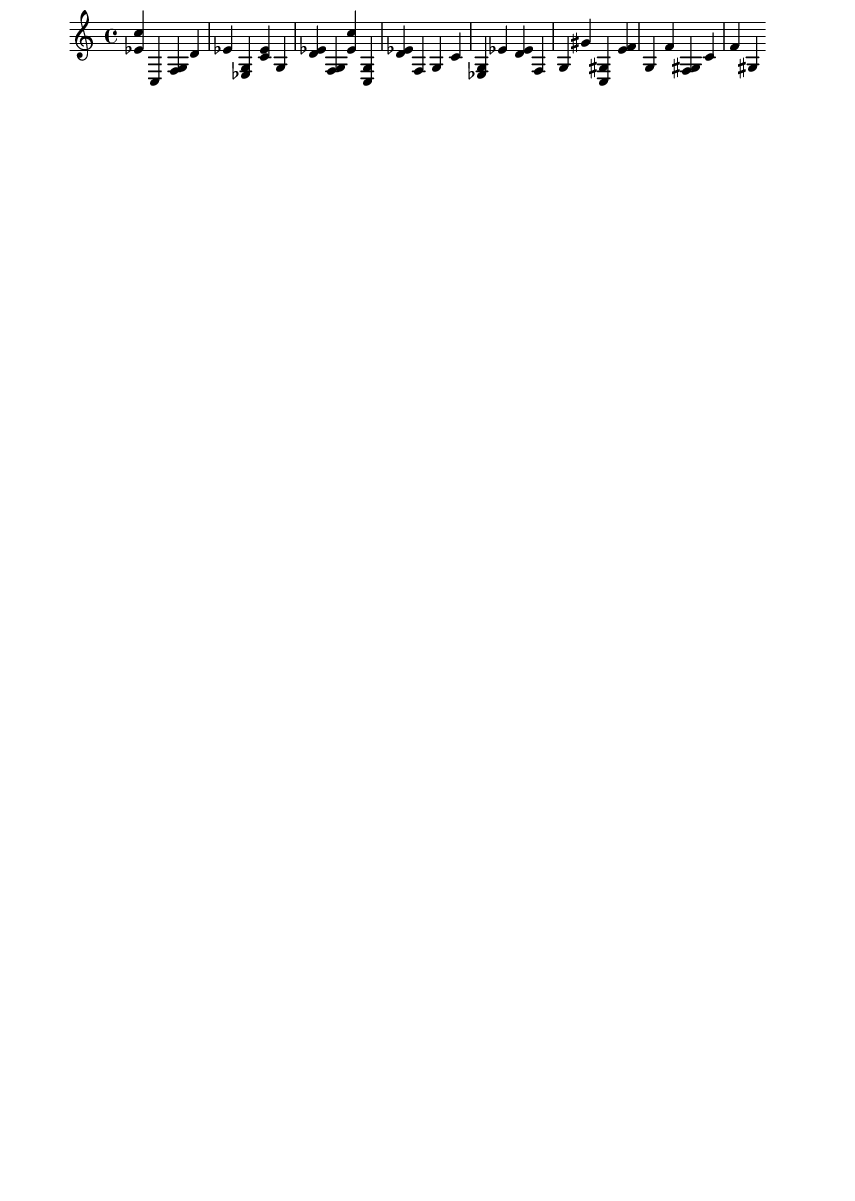

In [20]:
snippet = build_stream_from_sequence(Corpus2[:30])
print(snippet.flat.notes.show("text"))
show_stream_as_image(snippet)

## **Convertir `MIDI` a `WAV`**

> Esta parte no sirve aún, si se arregla **Modificar** este texto

In [ ]:
from midi2audio import FluidSynth

fs = FluidSynth()

# QUITAR ESTE COMENTARIO ↓
#fs.midi_to_audio(midi_file="data/bach/bach_846.mid", audio_file='output.wav')


In [15]:
# Reproducir dentro del notebook
display(Audio('output.wav'))

In [16]:
from IPython.display import Audio
snippet.write('midi', fp="data/bach/bach_846.mid")
display(Audio("data/bach/bach_846.mid"))
